## Analysis of business.json

#### Data loading (153 MB)

In [1]:
import pandas as pd

# read the entire file into a python array
with open('../yelp_dataset/yelp_academic_dataset_business.json', 'rb') as f:
    data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)
data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
df = pd.read_json(data_json_str)
print("business.json contains %i records, each composed by %i columns." % (df.shape[0], df.shape[1]))

business.json contains 209393 records, each composed by 14 columns.


#### Data preview

In [2]:
df.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,10913 Bailey Rd,"{u'BusinessParking': u'{'garage': False, 'stre...",f9NumwFMBDn751xgFiRbNA,"Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...",Cornelius,"{u'Monday': u'10:0-18:0', u'Tuesday': u'11:0-2...",1,35.462724,-80.852612,The Range At Lake Norman,28031,36,3.5,NC
1,"8880 E Via Linda, Ste 107","{u'GoodForKids': u'True', u'ByAppointmentOnly'...",Yzvjg0SayhoZgCljUJRF9Q,"Health & Medical, Fitness & Instruction, Yoga,...",Scottsdale,None,1,33.569404,-111.890264,"Carlos Santo, NMD",85258,4,5.0,AZ
2,3554 Rue Notre-Dame O,None,XNoUzKckATkOD1hP6vghZg,"Pets, Pet Services, Pet Groomers",Montreal,None,1,45.479984,-73.580070,Felinus,H4C 1P4,5,5.0,QC
3,1015 Sharp Cir,"{u'DogsAllowed': u'True', u'BusinessParking': ...",6OAZjbxqM5ol29BuHsil3w,"Hardware Stores, Home Services, Building Suppl...",North Las Vegas,"{u'Friday': u'7:0-16:0', u'Tuesday': u'7:0-16:...",0,36.219728,-115.127725,Nevada House of Hose,89030,3,2.5,NV
4,4827 E Downing Cir,"{u'BusinessAcceptsCreditCards': u'True', u'ByA...",51M2Kk903DFYI6gnB5I6SQ,"Home Services, Plumbing, Electricians, Handyma...",Mesa,"{u'Friday': u'9:0-16:0', u'Tuesday': u'9:0-16:...",1,33.428065,-111.726648,USE MY GUY SERVICES LLC,85205,26,4.5,AZ


#### Scatter plot (stars, review_count)

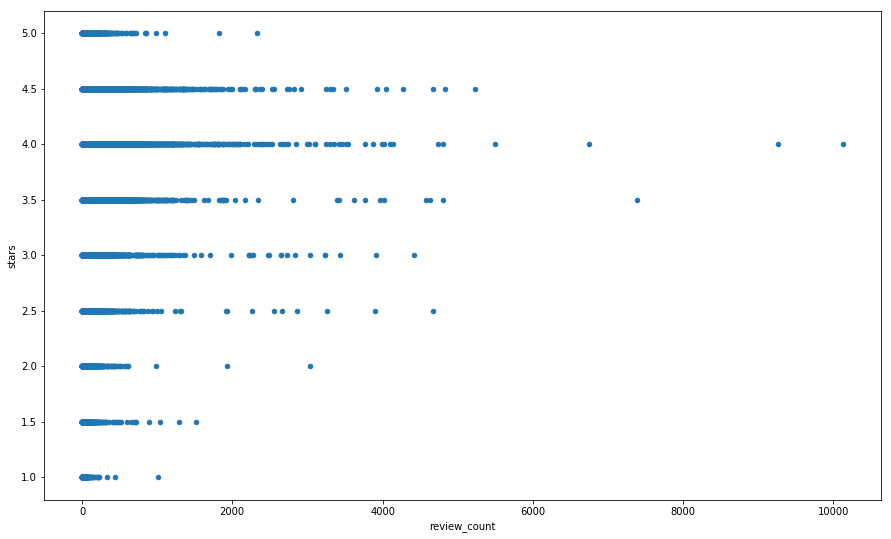

In [6]:
import matplotlib.pyplot as plt

df.plot.scatter(x='review_count', y='stars', figsize=(15,9))
plt.show()

#### Correlation matrix

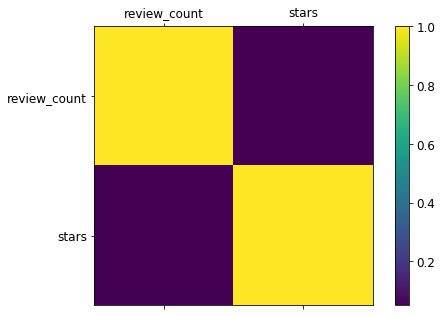

In [4]:
df_corr = df[['review_count', 'stars']]

f = plt.figure(figsize=(8, 5))
plt.matshow(df_corr.corr(), fignum=f.number)
plt.xticks(range(df_corr.shape[1]), df_corr.columns, fontsize=12)
plt.yticks(range(df_corr.shape[1]), df_corr.columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)

#### Location of businesses

All of business are located in North America.

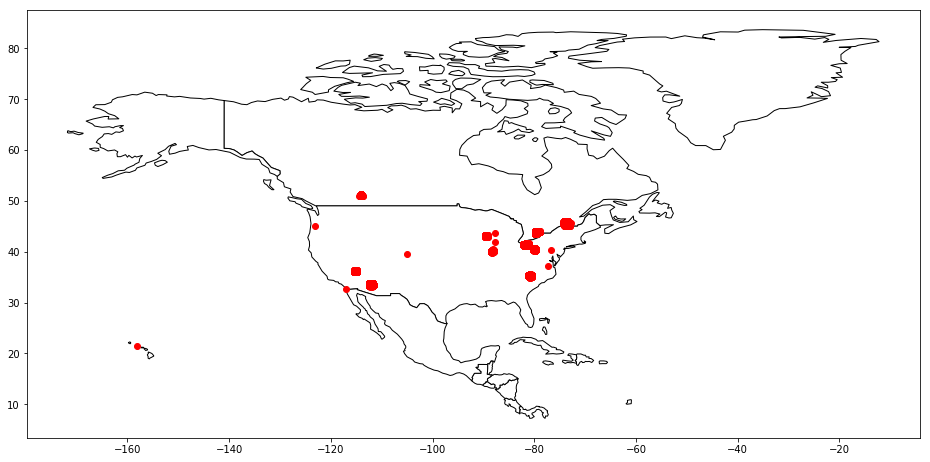

In [5]:
import geopandas

gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.longitude, df.latitude))
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world[world.continent == 'North America'].plot(color='white', edgecolor='black', figsize=(16,9))
gdf.plot(ax=ax, color='red', figsize=(16,9))
plt.show()

#### Cities with most businesses

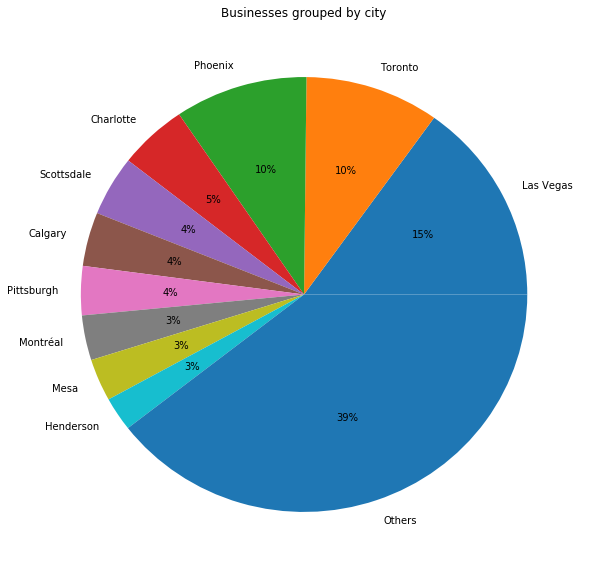

In [23]:
cities = df[['city', 'state']]
grouped_cities = cities.groupby(['city', 'state']).size().reset_index(name='count')
grouped_cities = grouped_cities.set_index('city')
grouped_cities = grouped_cities.sort_values(by=['count'], ascending=False)

grouped_cities2 = grouped_cities[:10].copy()
new_row = pd.DataFrame(data = {'city' : 'Others', 'state' : 'Others', 'count' : [grouped_cities[10:]['count'].sum()]})
new_row = new_row.set_index('city')
grouped_cities2 = pd.concat([grouped_cities2, new_row], sort=False)

ax = grouped_cities2.plot.pie(x='city', y='count', legend=False, figsize=(10,10), autopct='%1.0f%%')
ax.set_ylabel('')
ax.set_title('Businesses grouped by city')
plt.show()

#### States with most businesses

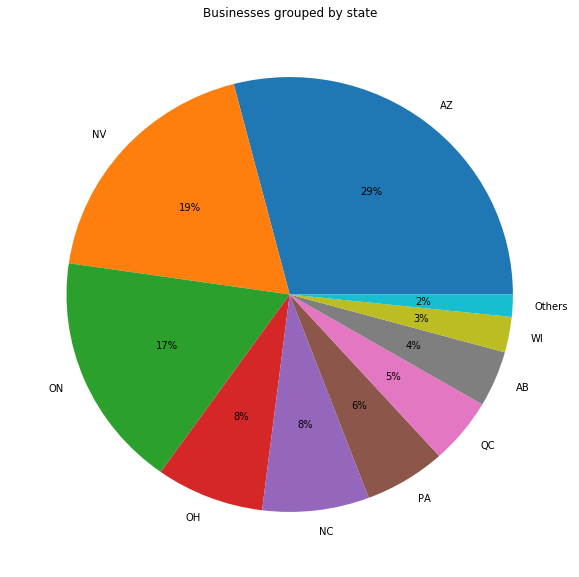

In [21]:
states = df[['state']]
grouped_states = states.groupby(['state']).size().reset_index(name='count')
grouped_states = grouped_states.set_index('state')
grouped_states = grouped_states.sort_values(by=['count'], ascending=False)

grouped_states2 = grouped_states[:9].copy()
new_row = pd.DataFrame(data = {'state' : 'Others', 'count' : [grouped_states[9:]['count'].sum()]})
new_row = new_row.set_index('state')
grouped_states2 = pd.concat([grouped_states2, new_row], sort=False)

ax = grouped_states2.plot.pie(x='city', y='count', legend=False, figsize=(10,10), autopct='%1.0f%%')
ax.set_ylabel('')
ax.set_title('Businesses grouped by state')
plt.show()

#### Opened business by hour

We want to know the number of businesses that are opened for each hour of the day and for each day of the week.

In [20]:
days_num = {'Monday': 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4, "Friday": 5, "Saturday": 6, "Sunday": 7}
days = ['Monday', "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
# Days of the week in rows and hours of the day in columns
timetable = [[0 for x in range(24)] for y in range(7)]
for o in df[['hours']].values:
    # Not all business have opening time
    if o[0] != None:
        week = {}
        for day in o[0]:
            time = o[0][day].split('-')
            opening_hour =  int(time[0].split(':')[0])
            opening_min =  int(time[0].split(':')[1])
            closing_hour =  int(time[1].split(':')[0])
            closing_min =  int(time[1].split(':')[1])
            for i in range(opening_hour, closing_hour):
                timetable[days_num[day]-1][i] = timetable[days_num[day]-1][i] + 1
df_hours = pd.DataFrame(data=timetable, index=days)
df_hours

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Monday,168,178,184,212,669,2837,8179,21440,42352,66896,...,105029,103763,100665,82126,65906,53242,41631,22015,6960,0
Tuesday,152,163,174,206,688,3043,9266,25403,50363,80716,...,129812,127978,124137,102536,80622,63707,48750,25497,7738,0
Wednesday,148,160,165,198,675,3010,9073,25250,50396,81036,...,131375,129935,126447,105183,83427,66203,50913,26544,8073,0
Thursday,157,170,176,205,655,2942,9181,25482,50670,81090,...,130989,129519,125978,105108,85147,67718,51456,26589,8294,0
Friday,203,214,220,247,713,3002,9114,25223,50360,80959,...,125290,123079,118933,98223,77019,61393,48250,28089,10962,0
Saturday,164,173,179,197,466,1794,5664,14978,32339,60115,...,97776,93466,87977,75102,60469,51226,42770,26780,10645,0
Sunday,250,274,279,299,570,1688,4490,10017,17628,27865,...,74964,72758,69488,57987,46407,40121,32860,20292,6545,0


Now we want to plot the table above in a heatmap.

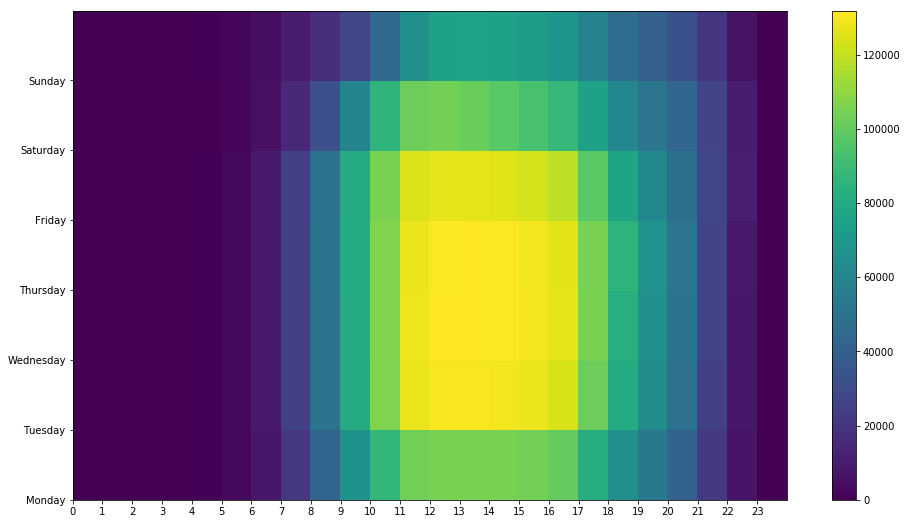

In [21]:
f = plt.figure(figsize=(16, 9))
plt.pcolor(df_hours)
plt.yticks(range(len(df_hours.index)), df_hours.index)
plt.xticks(range(len(df_hours.columns)), df_hours.columns)
plt.colorbar()
plt.show()